### Download data from here: https://www.kaggle.com/retailrocket/ecommerce-dataset

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import tensorflow.keras as keras
print("Keras:{}".format(keras.__version__))

import os
import sys
print('Python interpreter and version:',sys.version)

NumPy:1.16.2
Pandas:0.24.2
TensorFlow:1.13.1
Keras:2.2.4-tf
Python interpreter and version: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [2]:
dsroot = os.path.join(os.getcwd(),
                      'datasetslib',
                      'data',
                      'retailrocket-recommender-system-dataset')
os.listdir(dsroot)

['category_tree.csv',
 'item_properties_part1.csv',
 'events.csv',
 'item_properties_part2.csv']

In [3]:
events = pd.read_csv(os.path.join(dsroot,'events.csv'))
print('Event data\n',events.head())

Event data
        timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN


In [4]:
print('Unique counts:',events.nunique())

Unique counts: timestamp        2750455
visitorid        1407580
event                  3
itemid            235061
transactionid      17672
dtype: int64


In [5]:
print('Kind of events:',events.event.unique())

Kind of events: ['view' 'addtocart' 'transaction']


In [6]:
events.event.replace(to_replace=dict(view=1, 
                                     addtocart=2, 
                                     transaction=3), 
                     inplace=True)
events.drop(['transactionid'],axis=1,inplace=True)
events.drop(['timestamp'],axis=1,inplace=True)
#events = events.sample(frac=1).reset_index(drop=True)
events = events.reindex(np.random.permutation(events.index))
#events=events[0:100000]

In [7]:
split_1 = int(0.8 * len(events))
split_2 = int(0.9 * len(events))
train = events[:split_1]
valid = events[split_1:split_2]
test = events[split_2:]
print(train.head())
print(valid.head())
print(test.head())

         visitorid  event  itemid
1621867     896963      1  264947
1060311    1102098      1  431592
114317     1241997      1  283584
1658382     198153      1   97879
2173151    1278262      1  218178
         visitorid  event  itemid
1903213      85425      1  344338
1722815    1085328      1   59691
1388040    1366284      1  248032
2669880     478634      1  388940
1893864    1052918      1  328647
         visitorid  event  itemid
1004940     193171      1   11565
642906      704648      1  262522
902126       10212      1   46971
569976      753933      1   29489
1517206     261457      1  154821


In [8]:
n_visitors = events.visitorid.nunique()
n_items = events.itemid.nunique()
n_latent_factors = 5

In [9]:
from tensorflow.keras.layers import Input, Embedding, Flatten
item_input = Input(shape=[1],name='Items')
item_embed = Embedding(n_items + 1,
                       n_latent_factors, 
                       name='ItemsEmbedding')(item_input)
item_vec = Flatten(name='ItemsFlatten')(item_embed)

visitor_input = Input(shape=[1],name='Visitors')
visitor_embed = Embedding(n_visitors + 1,
                          n_latent_factors,
                          name='VisitorsEmbedding')(visitor_input)
visitor_vec = Flatten(name='VisitorsFlatten')(visitor_embed)

dot_prod = keras.layers.dot([item_vec, visitor_vec],axes=[1,1],
                             name='DotProduct') 
model = keras.Model([item_input, visitor_input], dot_prod)
model.compile('adam', 'mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Items (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Visitors (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
ItemsEmbedding (Embedding)      (None, 1, 5)         1175310     Items[0][0]                      
__________________________________________________________________________________________________
VisitorsEmbedding (Embedding)   (None, 1, 5)         7037905     Visitors[0][0]                   
__________________________________________________________________________________________________
ItemsFlatt

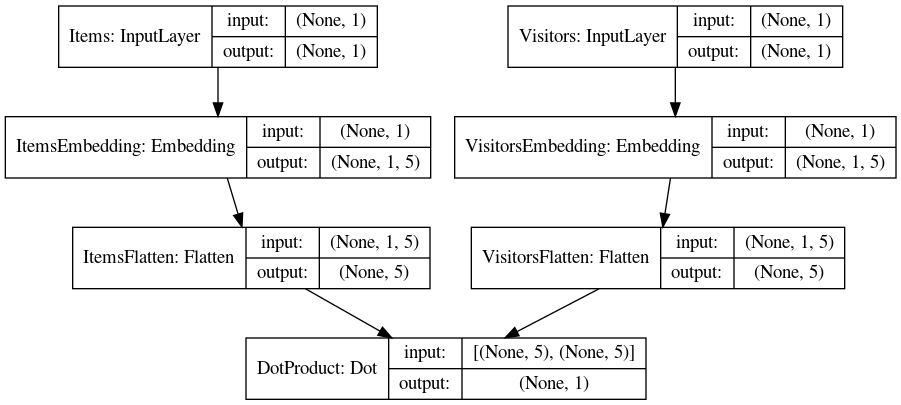

In [11]:
keras.utils.plot_model(model, 
                       to_file='model.png', 
                       show_shapes=True, 
                       show_layer_names=True)
from IPython import display
display.display(display.Image('model.png'))

In [12]:
model.fit([train.visitorid, train.itemid], train.event, epochs=1)

Instructions for updating:
Use tf.cast instead.
 921856/2204880 [===========>..................] - ETA: 6:46 - loss: nan

/home/taeho/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/taeho/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2204880/2204880 [==============================] - 392s 178us/sample - loss: nan


In [13]:
score = model.evaluate([test.visitorid, test.itemid], test.event)
print('mean squared error:', score)

275611/275611 [==============================] - 4s 16us/sample - loss: 8.1220
mean squared error: 8.122031029289946


In [14]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense

n_lf_visitor = 5
n_lf_item = 5

item_input = Input(shape=[1],name='Items')
item_embed = Embedding(n_items + 1,
                           n_lf_visitor, 
                           name='ItemsEmbedding')(item_input)
item_vec = Flatten(name='ItemsFlatten')(item_embed)

visitor_input = Input(shape=[1],name='Visitors')
visitor_embed = Embedding(n_visitors + 1, 
                              n_lf_item,
                              name='VisitorsEmbedding')(visitor_input)
visitor_vec = Flatten(name='VisitorsFlatten')(visitor_embed)

concat = keras.layers.concatenate([item_vec, visitor_vec], name='Concat')
fc_1 = Dense(80,name='FC-1')(concat)
fc_2 = Dense(40,name='FC-2')(fc_1)
fc_3 = Dense(20,name='FC-3', activation='relu')(fc_2)

output = Dense(1, activation='relu',name='Output')(fc_3)

optimizer = keras.optimizers.Adam(lr=0.001)
model = keras.Model([item_input, visitor_input], output)
model.compile(optimizer=optimizer,loss= 'mse')

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Items (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Visitors (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
ItemsEmbedding (Embedding)      (None, 1, 5)         1175310     Items[0][0]                      
__________________________________________________________________________________________________
VisitorsEmbedding (Embedding)   (None, 1, 5)         7037905     Visitors[0][0]                   
__________________________________________________________________________________________________
ItemsFlatt

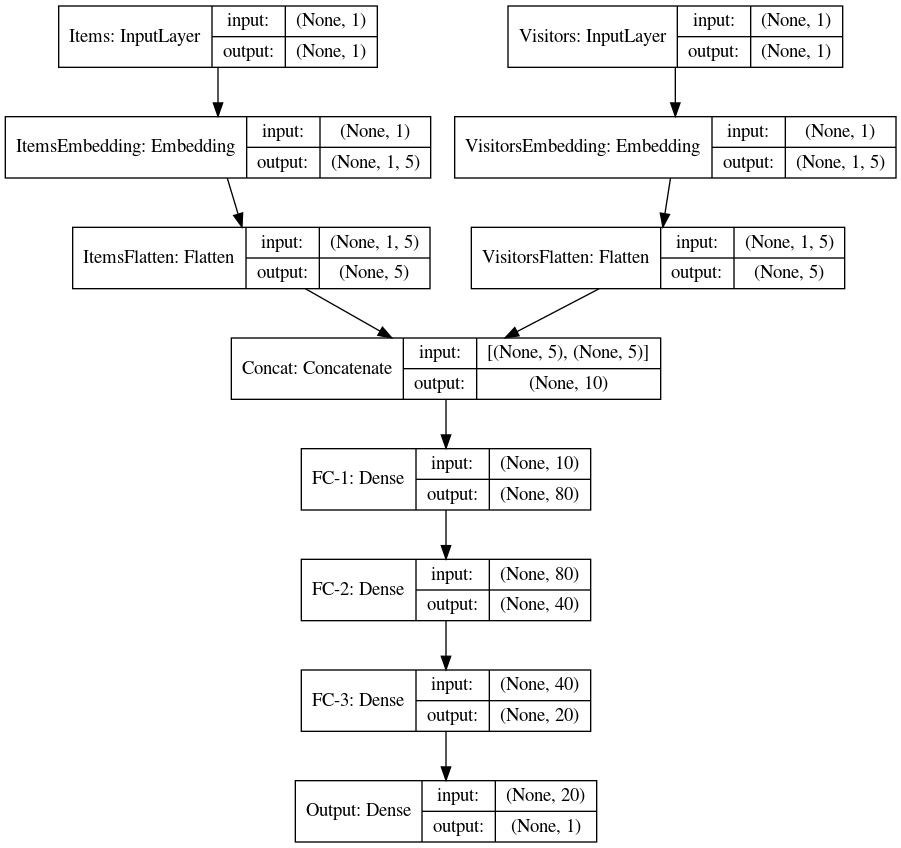

In [16]:
keras.utils.plot_model(model, 
                       to_file='model.png', 
                       show_shapes=True, 
                       show_layer_names=True)
from IPython import display
display.display(display.Image('model.png'))

In [17]:
model.fit([train.visitorid, train.itemid], train.event, epochs=1)

2204880/2204880 [==============================] - 678s 308us/sample - loss: 0.0720


In [18]:
score = model.evaluate([test.visitorid, test.itemid], test.event)
print('mean squared error:', score)

275611/275611 [==============================] - 5s 19us/sample - loss: 0.0573
mean squared error: 0.05733495172091794
